### Suginamiku Real Estate Data Analysis 

*The dataset used in this notebook includes prices below $1 million*

Notebook Author: NGUYEN Dai Truong Thanh

Ritsumeikan Asia Pacific University

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pandas.plotting import scatter_matrix
from scipy import stats
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print("Libraries imported.")
print(tf.__version__)

Libraries imported.
2.3.1


In [2]:
path = "../input/suginami-data/suginamiku_cleaned_data_1m.csv"

suginami_data = pd.read_csv(path, index_col=0)
suginami_data.head(2)

,type,transaction_period,building_structure,city_planning,construction_year,location,nearest_station,distance_to_station,area,building_age,maximum_coverage_ratio,maximum_floor_area_ratio,price
0,"Pre-owned Condominiums, etc.",1st quarter 2020,RC,Category I Exclusively Low-story Residential Zone,1984,Asagayakita,Asagaya,10,15,36,0.6,1.5,95060.0
1,"Pre-owned Condominiums, etc.",1st quarter 2020,RC,Neighborhood Commercial Zone,2006,Asagayakita,Asagaya,14,20,14,0.8,3.0,194000.0


In [3]:
suginami_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type                      5517 non-null   object 
 1   transaction_period        5517 non-null   object 
 2   building_structure        5517 non-null   object 
 3   city_planning             5517 non-null   object 
 4   construction_year         5517 non-null   int64  
 5   location                  5517 non-null   object 
 6   nearest_station           5517 non-null   object 
 7   distance_to_station       5517 non-null   int64  
 8   area                      5517 non-null   int64  
 9   building_age              5517 non-null   int64  
 10  maximum_coverage_ratio    5517 non-null   float64
 11  maximum_floor_area_ratio  5517 non-null   float64
 12  price                     5517 non-null   float64
dtypes: float64(3), int64(4), object(6)
memory usage: 603.4+ KB


In [4]:
selected_columns = ["location","building_structure","nearest_station","distance_to_station",
                    "area","maximum_coverage_ratio",
                    "maximum_floor_area_ratio","building_age","price"]

num_attributes = ["distance_to_station","area","maximum_coverage_ratio",
                    "maximum_floor_area_ratio","building_age"]

cat_attributes = ["building_structure","location","nearest_station"]

label = "price"

In [5]:
dataset = suginami_data[selected_columns].copy()

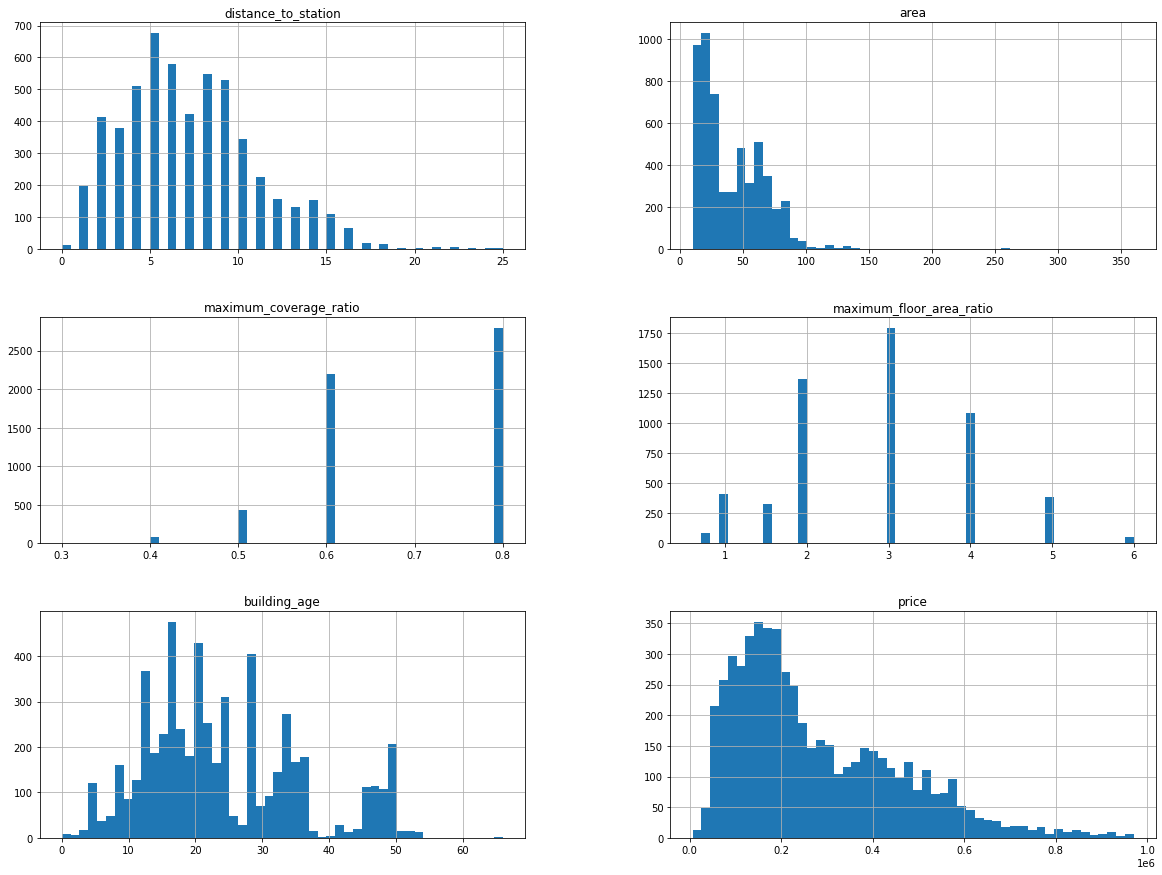

In [6]:
# historgram plots

dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# check for correlations 

corr_matrix = dataset.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                       1.000000
area                        0.836160
distance_to_station         0.128858
maximum_floor_area_ratio   -0.232123
maximum_coverage_ratio     -0.279237
building_age               -0.405785
Name: price, dtype: float64


* area has **very strong positive** correlation with price.
* distance_to_station has **weak positive** correlation with price.
* maximum_coverage_ratio and maximum_floor_area_ratio have **weak negative** correlations with price.
* building_age has **negative** correlation with price.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f911bfc5a10>,
      dtype=object)

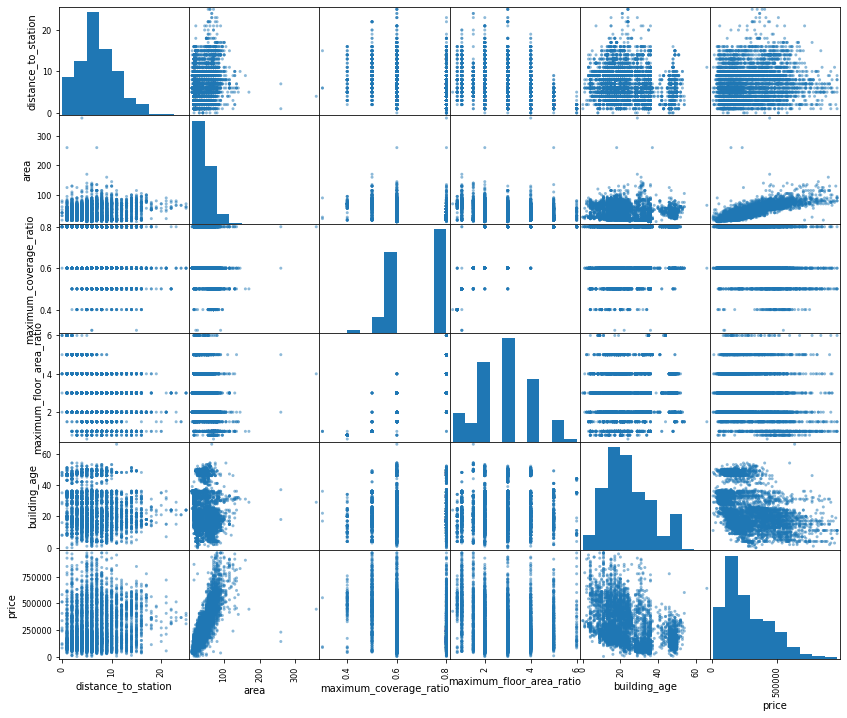

In [8]:
scatter_matrix(dataset, figsize=(14, 12))

In [9]:
# split the dataset

train_set, test_set = train_test_split(dataset, test_size=0.1, random_state=42)
print(len(train_set))
print(len(test_set))

4965
552


### Linear Regression Models

In [10]:
def lin_reg(x):
    lm = LinearRegression()

    pearson_coef, p_value = stats.pearsonr(train_set[x], train_set["price"])
    print("Pearson Coefficient =",pearson_coef, "and P-value =", p_value)
    print("")

    lm.fit(train_set[[x]], train_set["price"])

    print("Slope: ", lm.coef_)
    print("Intercept: ", lm.intercept_)
    print("")
    if float(lm.coef_) >= 0:
        print("Linear Model: price =", lm.intercept_, "+", float(lm.coef_), "*", x)
    else:
        print("Linear Model: price =", lm.intercept_, float(lm.coef_), "*", x)

In [11]:
area_lm = lin_reg("area")

Pearson Coefficient = 0.8305932287378068 and P-value = 0.0

Slope:  [6144.96702697]
Intercept:  27893.49510815824

Linear Model: price = 27893.49510815824 + 6144.967026967049 * area


In [12]:
building_age_lm = lin_reg("building_age")

Pearson Coefficient = -0.4075422597669153 and P-value = 5.009434693985662e-198

Slope:  [-6332.83511743]
Intercept:  428425.6271664329

Linear Model: price = 428425.6271664329 -6332.835117425971 * building_age


In [13]:
time_to_station = lin_reg("distance_to_station")

Pearson Coefficient = 0.12694037093359867 and P-value = 2.740879967341531e-19

Slope:  [6098.88522951]
Intercept:  232855.88640427997

Linear Model: price = 232855.88640427997 + 6098.885229505248 * distance_to_station


### Multiple Linear Regression Model

In [14]:
# Multiple linear regression model using all numerical attributes. 

mul_reg = LinearRegression()

mul_reg.fit(train_set[num_attributes], train_set[label])

print("Slope: ", mul_reg.coef_)
print("Intercept: ", mul_reg.intercept_)

Slope:  [ -3246.72296296   5925.56588596 -93877.30904591   5942.13245522
  -5082.79377867]
Intercept:  230090.40225562506


#### Multiple linear regression model to predict price of a building in Suginami-ku:

> price = 230090.40 - 3246.72\*distance_to_station + 5925.56\*area - 93877.31\*maximum_coverage_ratio + 5942.13\*maximum_floor_area_ratio - 5082.79\*building_age 

In [15]:
lin_predictions = mul_reg.predict(train_set[num_attributes])
lin_mse = mean_squared_error(train_set[label], lin_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Prediction error: $",int(lin_rmse))

Prediction error: $ 81904


In [16]:
# function that compares predictions vs actual values

def plot_com(actual, preds):
    plt.figure(figsize=(12, 8))

    ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
    sns.distplot(preds, hist=False, color="b", label="Fitted Values" , ax=ax1)

    plt.title('Actual vs Fitted Values for Price')
    plt.xlabel('Price (in dollars)')

    plt.show()
    plt.close()

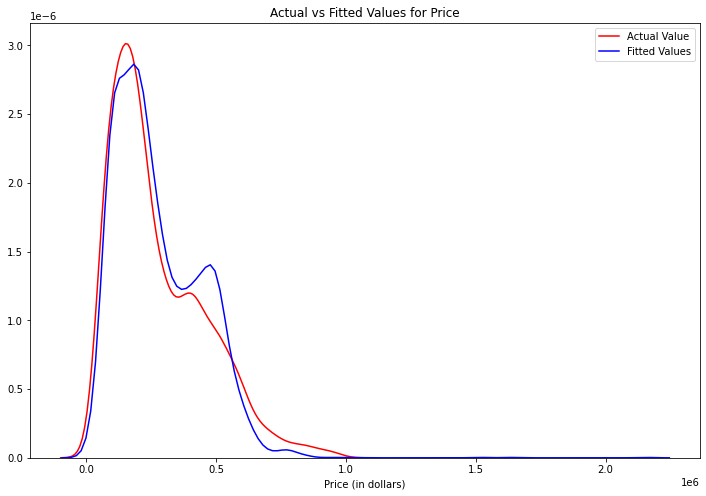

In [17]:
plot_com(train_set[label], lin_predictions)

### Decision Tree Regression Model

In [18]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set[num_attributes], train_set[label])

DecisionTreeRegressor(random_state=42)

In [19]:
tree_predictions = tree_reg.predict(train_set[num_attributes])
tree_mse = mean_squared_error(train_set[label], tree_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Prediction error: $",int(tree_rmse))

Prediction error: $ 29804


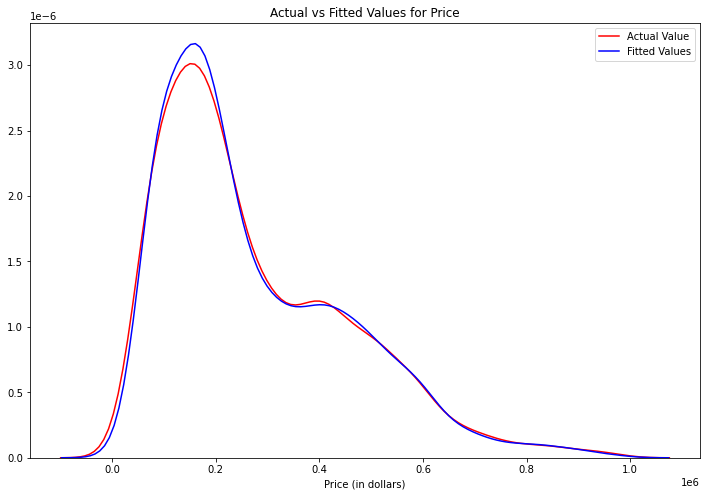

In [20]:
plot_com(train_set[label], tree_predictions)

### Random Forest Regression Model

In [21]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_set[num_attributes], train_set[label])

RandomForestRegressor(random_state=42)

In [22]:
forest_predictions = forest_reg.predict(train_set[num_attributes])
forest_mse = mean_squared_error(train_set[label], forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Prediction error: $",int(forest_rmse))

Prediction error: $ 35271


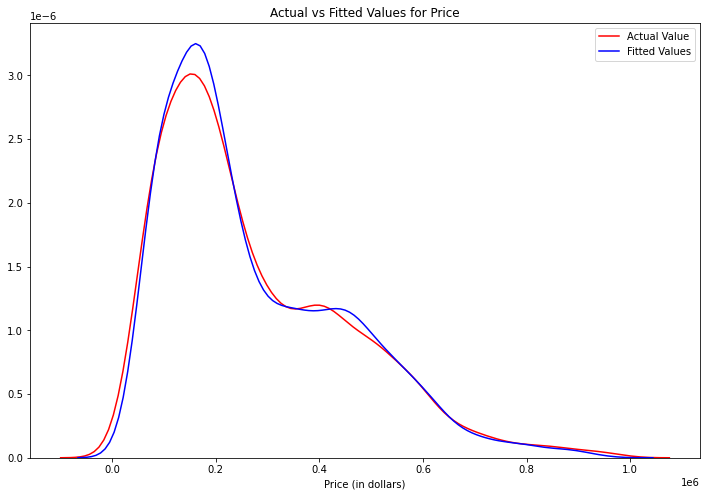

In [23]:
plot_com(train_set[label], forest_predictions)

### Linear Regression Model with Polynomial Features

In [24]:
input = [("scale",StandardScaler()),
         ("polynomial",PolynomialFeatures(include_bias=False)),
         ("model",LinearRegression())]

pipe = Pipeline(input)
pipe.fit(train_set[num_attributes], train_set[label])

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [25]:
pipe_predictions = pipe.predict(train_set[num_attributes])
pipe_mse = mean_squared_error(train_set[label], pipe_predictions)
pipe_rmse = np.sqrt(pipe_mse)
print("Prediction error: $",int(pipe_rmse))

Prediction error: $ 67587


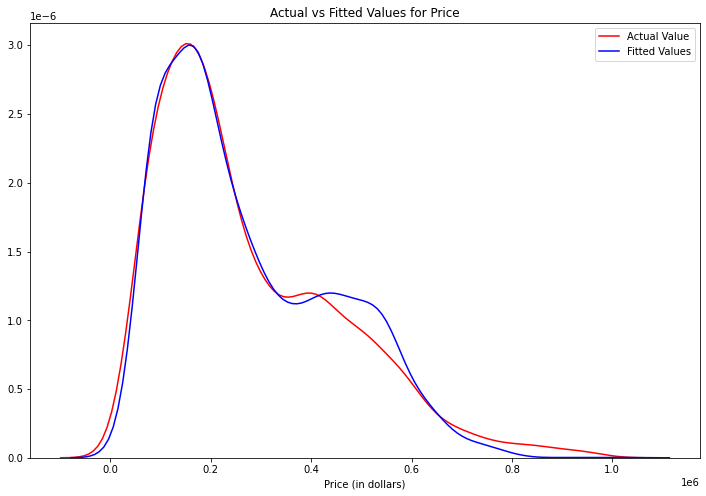

In [26]:
plot_com(train_set[label], pipe_predictions)

### Deep Neural Network Regression Model

In [27]:
# import normalized data for DNN model

path = "../input/suginami-data/suginamiku_data_norm_1m.csv"

norm_data = pd.read_csv(path, index_col=0)

norm_dataset = norm_data.copy()
norm_dataset.head(2)

,distance_to_station,area,maximum_coverage_ratio,maximum_floor_area_ratio,building_age,price
0,0.40,0.014286,0.6,0.166667,0.545455,0.092099
1,0.56,0.028571,1.0,0.444444,0.212121,0.194766


In [28]:
# features

X = norm_dataset.iloc[:, :5]
print(X.head())

# labels

Y = norm_dataset.iloc[:, -1]
print(Y.head())

   distance_to_station      area  maximum_coverage_ratio  \
0                 0.40  0.014286                     0.6   
1                 0.56  0.028571                     1.0   
2                 0.12  0.085714                     1.0   
3                 0.32  0.128571                     1.0   
4                 0.56  0.100000                     1.0   

   maximum_floor_area_ratio  building_age  
0                  0.166667      0.545455  
1                  0.444444      0.212121  
2                  0.814815      0.242424  
3                  0.629630      0.015152  
4                  0.444444      0.742424  
0    0.092099
1    0.194766
2    0.396074
3    0.808757
4    0.245093
Name: price, dtype: float64


In [29]:
X_arr = X.values
Y_arr = Y.values

print("X_arr shape: ", X_arr.shape)
print("Y_arr shape: ", Y_arr.shape)

X_arr shape:  (5517, 5)
Y_arr shape:  (5517,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.1, shuffle = True, random_state=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (4965, 5)
y_train shape:  (4965,)
X_test shape:  (552, 5)
y_test shape:  (552,)


In [31]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [32]:
def dnn_model():
    
    model = Sequential([
        Dense(10, input_shape = (5,), activation = "relu"),
        Dense(20, activation = "relu"),
        Dense(5, activation = "relu"),
        Dense(1)])

    model.compile(
        optimizer = "rmsprop", 
        loss = root_mean_squared_error, 
        metrics = ["accuracy"])
    
    return model

dnn_reg = dnn_model()
dnn_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stopping = EarlyStopping(monitor="val_loss", patience = 5)

preds_on_untrained = dnn_reg.predict(X_test)

history = dnn_reg.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping],
    verbose = 0)

In [34]:
print("---Training loss---")
print(history.history["loss"])
print("")
print("---Validation loss---")
print(history.history["val_loss"])

---Training loss---
[0.186968132853508, 0.13734839856624603, 0.09007401019334793, 0.07750236243009567, 0.07610329985618591, 0.07541049271821976, 0.07425043731927872, 0.07350720465183258, 0.07334136962890625, 0.0730244591832161, 0.07285422086715698, 0.07176682353019714, 0.07181618362665176, 0.07214311510324478, 0.0714438334107399, 0.07151345163583755, 0.07139145582914352, 0.07094548642635345, 0.07104409486055374]

---Validation loss---
[0.15939554572105408, 0.10743075609207153, 0.08108831197023392, 0.09670212119817734, 0.08450762182474136, 0.08851460367441177, 0.08054836094379425, 0.07860001176595688, 0.0856110230088234, 0.08712901175022125, 0.07549869269132614, 0.08277172595262527, 0.0841335877776146, 0.07543361932039261, 0.08212113380432129, 0.08887173235416412, 0.0947391465306282, 0.10216961055994034, 0.12245381623506546]


In [35]:
price_max = dataset["price"].max()
print(price_max)
price_min = dataset["price"].min()
print(price_min)

def convert_price_values(pred):
    return int((pred*(price_max-price_min) + price_min))

970000.0
6305.0


In [36]:
loss_usd = []

for l in history.history["loss"]:
    loss_usd.append(convert_price_values(l))

In [37]:
val_loss_usd = []

for l in history.history["val_loss"]:
    val_loss_usd.append(convert_price_values(l))

In [38]:
print("Prediction loss:",loss_usd)
print("Validation loss:",val_loss_usd)

Prediction loss: [186485, 138666, 93108, 80993, 79645, 78977, 77859, 77143, 76983, 76678, 76514, 75466, 75513, 75828, 75155, 75222, 75104, 74674, 74769]
Validation loss: [159913, 109835, 84449, 99496, 87744, 91606, 83929, 82051, 88807, 90270, 79062, 86071, 87384, 79000, 85444, 91950, 97604, 104765, 124313]


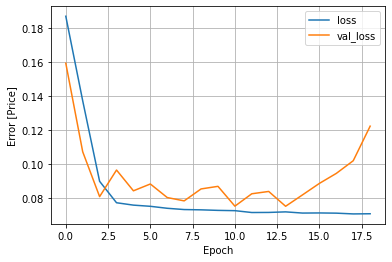

In [39]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Price]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

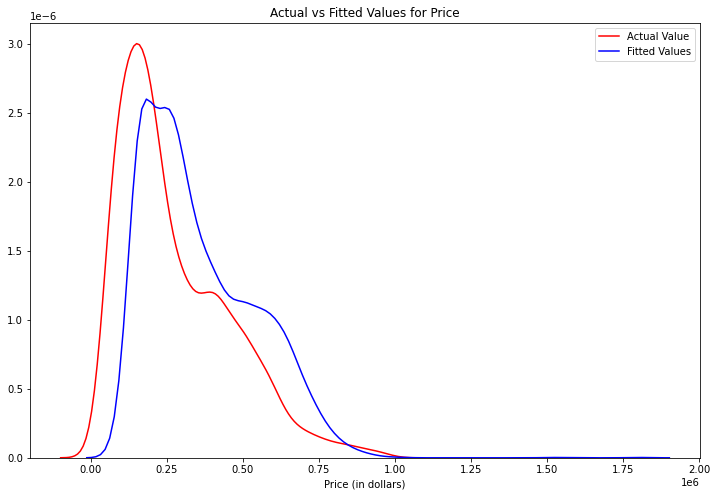

In [40]:
preds = dnn_reg.predict(X_train)

price_preds = [convert_price_values(y) for y in preds]
price_labels = [convert_price_values(y) for y in y_train]
plot_com(price_labels, price_preds)

### Decision Tree Regression with Numerical & Categorical Attributes

In [41]:
num_pipeline = Pipeline([
        ("scale",StandardScaler()),
        ("polynomial",PolynomialFeatures(include_bias=False)),
])

In [42]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes)
])

In [43]:
nc_pipe = full_pipeline.fit_transform(train_set)

In [44]:
nc_tree_reg = DecisionTreeRegressor()
nc_tree_reg.fit(nc_pipe, train_set["price"])

DecisionTreeRegressor()

In [45]:
nc_tree_predictions = nc_tree_reg.predict(nc_pipe)
nc_tree_mse = mean_squared_error(train_set["price"], nc_tree_predictions)
nc_tree_rmse = np.sqrt(nc_tree_mse)
print("Prediction error: $",int(nc_tree_rmse))

Prediction error: $ 27145


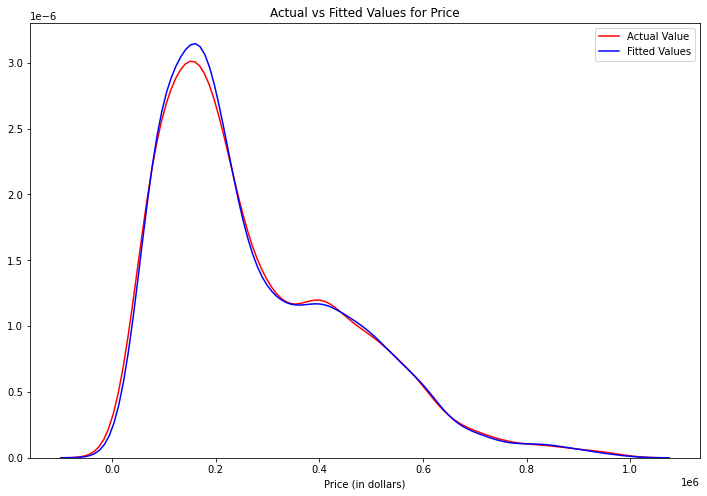

In [46]:
plot_com(train_set[label], nc_tree_predictions)

### Model Performances on Train Dataset

In [47]:
models_errors = {"Model":["Multiple Linear Regression","Decision Tree Regression","Random Forest Regression",
                      "DNN Regression", "MLR with Polynomial Features", 
                      "Decision Tree with Num&Cat Attributes"],
                  "Prediction Error (USD)":[lin_rmse,tree_rmse,forest_rmse,85202,pipe_rmse,nc_tree_rmse]}

com_table = pd.DataFrame(data=models_errors)

In [48]:
com_table.sort_values(by=["Prediction Error (USD)"], inplace=True, ascending=False)
com_table.reset_index(drop=True, inplace=True)
com_table

,Model,Prediction Error (USD)
0,DNN Regression,85202.000000
1,Multiple Linear Regression,81904.147853
2,MLR with Polynomial Features,67587.514562
3,Random Forest Regression,35271.879786
4,Decision Tree Regression,29804.026381
5,Decision Tree with Num&Cat Attributes,27145.664357
